In [12]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt

df = pd.read_csv('data/testbbo.csv') # Dont run it with tail 1000!
df['Time'] = pd.to_datetime(df['TimeT'])
df.set_index('Time', inplace=True)
df_active = df[df['TradingStatus'] == 'T']

# Initialize an empty dictionary to store ticker data
ticker_data = {}


In [2]:


mini_vs_norm = [("VXV4", "VXMV4"), ("VXZ4", "VXMZ4")]

for norm, mini in mini_vs_norm:
    df_vxv4 = df_active[df_active['Symbol'] == norm][['BidPrice', 'BidQuantity', 'AskPrice', 'AskQuantity']]
    df_vxmv4 = df_active[df_active['Symbol'] == mini][['BidPrice', 'BidQuantity', 'AskPrice', 'AskQuantity']]
    # backfill prices by using the previous timestamp price
    df_arb = df_vxv4.merge(df_vxmv4, on='Time', how='outer',suffixes=('_'+norm, '_'+mini)).sort_values("Time").fillna(method='ffill').dropna()

    df_arb['Arb_1'] = df_arb['BidPrice_'+mini]  - df_arb['AskPrice_'+norm] # Buy Norm Sell Mini
    df_arb['Arb_2'] = df_arb['BidPrice_'+norm] - df_arb['AskPrice_'+mini]  # Buy Mini Sell Norm

    minibidq = "BidQuantity_"+mini
    miniaskq = "AskQuantity_"+mini
    normbidq = "BidQuantity_"+norm
    normaskq = "AskQuantity_"+norm

    UNIT_SIZE = 100
    # Long Normal Short Mini
    df_arb["Units_LNSM"] = df_arb.apply(lambda row: min(row[minibidq], row[normaskq] * 10), axis=1) # divide 10 for mini -> full
    #df_arb["Units_LNSM"] = df_arb[minibidq]
    # Long Mini Short Normal
    df_arb["Units_LMSN"] = df_arb.apply(lambda row: min(row[miniaskq], row[normbidq]* 10), axis=1) # divide 10 for mini -> full
    #df_arb["Units_LMSN"] = df_arb[miniaskq]

    df_arb["Profit_A1"] = (df_arb['Arb_1'] * df_arb["Units_LNSM"]).clip(lower=0) * UNIT_SIZE

    df_arb["Profit_A2"] = (df_arb['Arb_2'] * df_arb["Units_LMSN"]).clip(lower=0) * UNIT_SIZE

    fname = "MININORM_Arbitrage_" + mini + "_" + norm + ".csv"
    df_arb.to_csv("data/"+fname)

    sum_A1 = sum(df_arb["Profit_A1"])
    sum_A2 = sum(df_arb["Profit_A2"])

    print(f"A1 TOTAL THEORETICAL PnL: {sum_A1} ")
    print(f"A2 TOTAL THEORETICAL PnL: {sum_A2} ")
    





C:\Users\warre\AppData\Local\Temp\ipykernel_21452\1196653494.py:7: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_arb = df_vxv4.merge(df_vxmv4, on='Time', how='outer',suffixes=('_'+norm, '_'+mini)).sort_values("Time").fillna(method='ffill').dropna()


A1 TOTAL THEORETICAL PnL: 14712.000000000542 
A2 TOTAL THEORETICAL PnL: 13938.000000001115 


C:\Users\warre\AppData\Local\Temp\ipykernel_21452\1196653494.py:7: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_arb = df_vxv4.merge(df_vxmv4, on='Time', how='outer',suffixes=('_'+norm, '_'+mini)).sort_values("Time").fillna(method='ffill').dropna()


A1 TOTAL THEORETICAL PnL: 358.00000000000574 
A2 TOTAL THEORETICAL PnL: 675.0000000000113 


C:\Users\warre\AppData\Local\Temp\ipykernel_21452\2236724045.py:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_legs = df_short.merge(df_long, on='Time', how='outer',suffixes=('_'+short, '_'+long)).sort_values("Time").fillna(method='ffill').dropna()
C:\Users\warre\AppData\Local\Temp\ipykernel_21452\2236724045.py:7: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_arb = df_spread.merge(df_legs, on='Time', how='outer').sort_values("Time").fillna(method='ffill').dropna()


Triangle: Sell Spread: TOTAL THEORETICAL PnL: 423260.00000005687 
Triangle: Buy Spread: TOTAL THEORETICAL PnL: 2062760.0000000775 


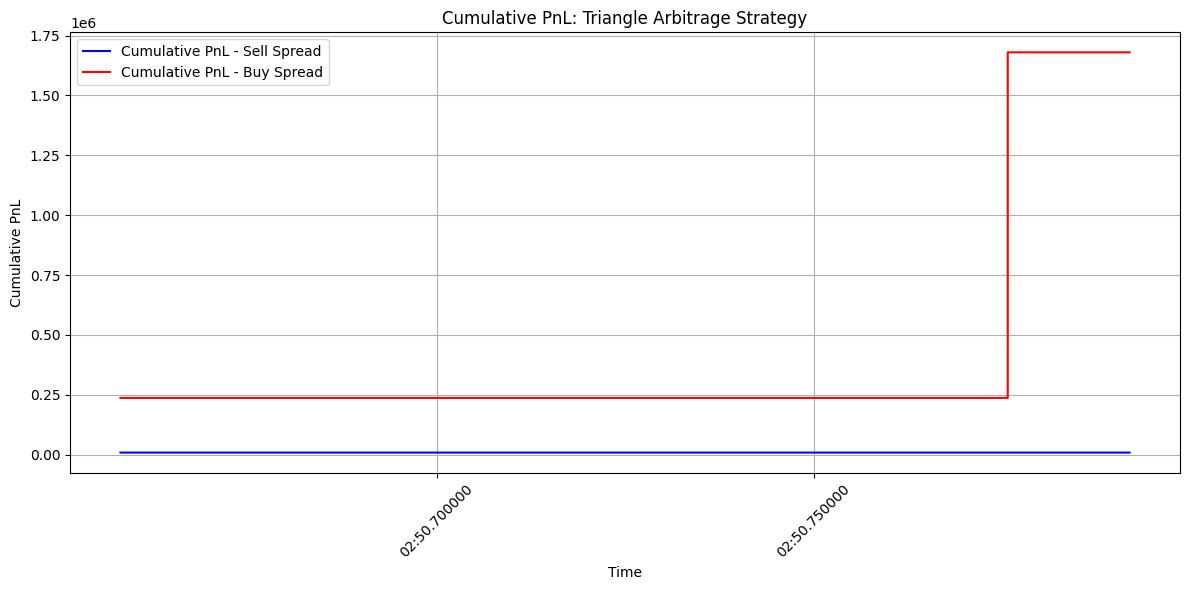

In [28]:
triangle = [("-VXX4+VXZ4", "VXX4", "VXZ4")]
for spread, short, long in triangle:
    df_spread = df_active[df_active['Symbol'] == spread][['BidPrice', 'BidQuantity', 'AskPrice', 'AskQuantity']]
    df_short = df_active[df_active['Symbol'] == short][['BidPrice', 'BidQuantity', 'AskPrice', 'AskQuantity']]
    df_long = df_active[df_active['Symbol'] == long][['BidPrice', 'BidQuantity', 'AskPrice', 'AskQuantity']]
    df_legs = df_short.merge(df_long, on='Time', how='outer',suffixes=('_'+short, '_'+long)).sort_values("Time").fillna(method='ffill').dropna()
    df_arb = df_spread.merge(df_legs, on='Time', how='outer').sort_values("Time").fillna(method='ffill').dropna()
    #df_arb.to_csv("debug.csv")
    #print(df_arb)
    # in a given -A+B contract, short is the short leg (A) and long is the long leg(B)
    # SELL -X+Z, SELL X, BUY Z
    df_arb['Arb_1'] = df_arb["BidPrice"]  + (df_arb['BidPrice_'+short] - df_arb['AskPrice_'+long]) # Short Spread Long Legs
    # BUY -X+Z, BUY X, SELL Z
    df_arb['Arb_2'] = -df_arb["AskPrice"]  - df_arb['AskPrice_'+short] + df_arb['BidPrice_'+long] # Long Spread Short Legs

    UNIT_SIZE = 1000
    # Buy spread, sell legs
    df_arb["Units_SSLL"] = df_arb.apply(lambda row: min(row['BidQuantity'], min(row['BidQuantity_'+short], row['AskQuantity_'+long])), axis=1) 
    # Sell spread, buy legs
    df_arb["Units_LSSL"] = df_arb.apply(lambda row: min(row['AskQuantity'], min(row['AskQuantity_'+short], row['BidQuantity_'+long])), axis=1)


    df_arb["Profit_Sell_Spread"] = (df_arb['Arb_1'] * df_arb["Units_SSLL"]).clip(lower=0) * UNIT_SIZE
    df_arb["Cumulative_PnL_Sell"] = df_arb["Profit_Sell_Spread"].cumsum()

    df_arb["Profit_Buy_Spread"] = (df_arb['Arb_2'] * df_arb["Units_LSSL"]).clip(lower=0) * UNIT_SIZE
    df_arb["Cumulative_PnL_Buy"] = df_arb["Profit_Buy_Spread"].cumsum()

    fname = "TRIANGLE_Arbitrage_" + spread + ".csv"
    df_arb.to_csv("data/"+fname)

    sum_A1 = sum(df_arb["Profit_Sell_Spread"])
    sum_A2 = sum(df_arb["Profit_Buy_Spread"])
    print(f"Triangle: Sell Spread: TOTAL THEORETICAL PnL: {sum_A1} ")
    print(f"Triangle: Buy Spread: TOTAL THEORETICAL PnL: {sum_A2} ")

    # Set filters
    #df_filter = df_arb.loc[:]
    df_filter = df_arb.loc["2024-10-08 15:02:50.650000":"2024-10-08 15:02:50.800000"]

    plt.figure(figsize=(12, 6))

    # Plot cumulative PnL for Sell Spread
    plt.plot(df_filter['Cumulative_PnL_Sell'], label='Cumulative PnL - Sell Spread', color='b')

    # Plot cumulative PnL for Buy Spread
    plt.plot(df_filter['Cumulative_PnL_Buy'], label='Cumulative PnL - Buy Spread', color='r')

    # Add labels and title
    plt.xlabel('Time')
    plt.ylabel('Cumulative PnL')
    plt.title('Cumulative PnL: Triangle Arbitrage Strategy')

    # Format the x-axis to show dates better
    plt.xticks(rotation=45)

    # Add a legend
    plt.legend()

    # Display the grid
    plt.grid(True)

    # Tight layout to avoid overlap of labels
    plt.tight_layout()

    # Show the plot
    plt.show()

    
    

    
    

If we took every single arbitrage opportunity (assuming they do not disappear, which tends to overcount arbitrage PnL as once an arb is eliminated, it should not be counted again), we will arrive at a level of arbitrage that undercounts the magnitude of the potential cross as we use basic L1 BBO data to generate these figures.